In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from functools import reduce
import time

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# %%
import os

def get_figures_path():
    target_suffix = os.path.join("Contrastive_Learning", "code", "ML_model", "figures")
    cwd = os.path.abspath(os.getcwd())
    parts = cwd.split(os.sep)
    for i in range(len(parts), 0, -1):
        candidate = os.sep.join(parts[:i])
        test_path = os.path.join(candidate, target_suffix)
        if os.path.isdir(test_path):
            return test_path
    raise FileNotFoundError(f"Path ending with '{target_suffix}' not found")


# --- Logit transformation function ---
def logit(p: pd.Series) -> pd.Series:
    """Converts PSI (0-1) to logit."""
    # Clip for numerical stability to avoid log(0) or log(1)
    p = p.clip(1e-6, 1.0 - 1e-6)
    return np.log(p / (1 - p))

# --- REVISED: Calculates delta-logit from wide PSI DataFrames ---
def get_delta_psi_logit(df: pd.DataFrame, tissue_cols: list, gt_df_full: pd.DataFrame) -> (pd.DataFrame, list):
    """
    Calculates delta-logit for a given wide DataFrame 'df' (predictions or GT)
    by aligning with the logit_mean_psi from the full ground truth 'gt_df_full'.
    Handles potential column name conflicts during merge.
    """
    # Ensure exon_id is present
    if 'exon_id' not in df.columns:
        raise ValueError("Input DataFrame 'df' must contain 'exon_id' column.")
    if 'exon_id' not in gt_df_full.columns:
         raise ValueError("Ground truth DataFrame 'gt_df_full' must contain 'exon_id' column.")
    if 'logit_mean_psi' not in gt_df_full.columns:
         raise ValueError("Ground truth DataFrame 'gt_df_full' must contain 'logit_mean_psi' column.")

    # Select only the necessary columns from ground truth for the merge
    gt_subset_for_merge = gt_df_full[['exon_id', 'logit_mean_psi']].copy()

    # Define potential suffixes
    suffix_original = '_original_df'
    suffix_from_gt = '_from_gt_df'

    # Perform the merge
    merged_df = pd.merge(
        df,
        gt_subset_for_merge,
        on='exon_id',
        how='left',
        suffixes=(suffix_original, suffix_from_gt)
    )

    # --- Determine the correct ground truth logit_mean_psi column name ---
    gt_logit_mean_col = 'logit_mean_psi'
    if f'logit_mean_psi{suffix_from_gt}' in merged_df.columns:
        gt_logit_mean_col = f'logit_mean_psi{suffix_from_gt}'
    elif 'logit_mean_psi' not in merged_df.columns:
        raise KeyError("Could not find the 'logit_mean_psi' column after merging.")

    # Handle cases where predictions are for exons not in gt_df
    if merged_df[gt_logit_mean_col].isnull().any():
        missing_count = merged_df[gt_logit_mean_col].isnull().sum()
        print(f"Warning: Found {missing_count} exons in input 'df' not found in ground truth. They will be dropped.")
        merged_df = merged_df.dropna(subset=[gt_logit_mean_col])
        if merged_df.empty:
             raise ValueError("After merging and dropping missing ground truth, the DataFrame is empty.")

    # Convert only the specified tissue columns to numeric
    psi_df = merged_df[tissue_cols].apply(pd.to_numeric, errors='coerce')

    # Detect if PSI values are given as percentages (> 1.5)
    if not psi_df.empty and (psi_df.max(skipna=True).max(skipna=True) > 1.5):
        print("Detected PSI values > 1.5, converting from 0-100 scale.")
        psi_df = psi_df / 100.0
    elif psi_df.empty:
         print("Warning: No valid PSI values found to process after filtering/conversion.")
         empty_delta_logit = pd.DataFrame(columns=['exon_id'] + tissue_cols)
         return empty_delta_logit, tissue_cols


    # Compute logit(PSI) for each tissue
    logit_psi_df = psi_df.apply(logit)

    # Subtract the correctly identified ground truth logit_mean_psi
    delta_logit_df = logit_psi_df.sub(merged_df[gt_logit_mean_col], axis=0)

    # Add the exon_id column back
    delta_logit_df['exon_id'] = merged_df['exon_id']

    # Ensure exon_id is the first column for consistency
    delta_logit_df = delta_logit_df[['exon_id'] + tissue_cols]

    return delta_logit_df, tissue_cols

In [3]:
# %%
# --- Loads and processes the ground truth PSI file ---
def load_ground_truth(filepath: str) -> (pd.DataFrame, list):
    """
    Loads the ground truth PSI CSV file and returns the
    wide DataFrame and the list of tissue columns.
    """
    print(f"Loading and processing Ground Truth from: {filepath}")
    df = pd.read_csv(filepath)
    
    # This column indexing is from your script
    meta_cols = [
        'exon_id', 'cassette_exon', 'alternative_splice_site_group', 'linked_exons',
        'mutually_exclusive_exons', 'exon_strand', 'exon_length', 'gene_type',
        'gene_id', 'gene_symbol', 'exon_location', 'exon_boundary',
        'chromosome', 'mean_psi', 'logit_mean_psi', 'chromosome.1'
    ]
    tissue_cols = [col for col in df.columns if col not in meta_cols]
    
    # --- NEW: Ensure PSI values are 0-1 ---
    # Check if max PSI is > 1.5, indicating 0-100 scale
    if not df[tissue_cols].empty and (df[tissue_cols].max(skipna=True).max(skipna=True) > 1.5):
        print("Ground Truth: Detected PSI values > 1.5, converting from 0-100 scale.")
        df[tissue_cols] = df[tissue_cols] / 100.0
    
    return df, list(tissue_cols)

# --- MODIFIED: Loads SOTA *predictions* ---
def load_sota_predictions(filepath: str) -> pd.DataFrame:
    """
    Loads SOTA delta-logit predictions (which are already delta-logit)
    and returns a long-format DataFrame.
    """
    print(f"Loading SOTA predictions from: {filepath}")
    
    file_extension = Path(filepath).suffix.lower()
    separator = '\t' if file_extension == '.tsv' else ','
        
    df = pd.read_csv(filepath, sep=separator)
    
    # Melt to long format
    melted_df = df.melt(
        id_vars=['exon_id'],
        var_name='tissue',
        value_name='pred_delta_logit' # This is the hardcoded column name from the original file
    )
    return melted_df

# --- MODIFIED: Loads single run *PSI predictions* ---
def load_single_run_predictions(results_folder: str, run_name: str=None) -> (pd.DataFrame, list):
    """
    Loads the raw PSI predictions for a single run
    and returns a wide DataFrame and the list of tissue columns.
    """
    if run_name is None:
        filepath = Path(results_folder) / 'tsplice_final_predictions_all_tissues.tsv'
    else:
        filepath = Path(results_folder) / run_name / 'tsplice_final_predictions_all_tissues.tsv'
    if not filepath.exists():
        raise FileNotFoundError(f"Prediction file not found at: {filepath}")
        
    print(f"Loading single run PSI predictions from: {filepath}")
    
    df = pd.read_csv(filepath, sep='\t')
    
    # This column indexing is from your script
    pred_cols = df.columns[1:]
    
    # --- NEW: Ensure PSI values are 0-1 ---
    if not df[pred_cols].empty and (df[pred_cols].max(skipna=True).max(skipna=True) > 1.5):
        print(f"Predictions ({run_name}): Detected PSI values > 1.5, converting from 0-100 scale.")
        df[pred_cols] = df[pred_cols] / 100.0
    
    return df, list(pred_cols)

In [4]:
# %%
# --- NEW: Generic RMSE Calculation Function ---
def calculate_rmse_by_tissue(
    pred_df: pd.DataFrame, 
    gt_df: pd.DataFrame, 
    gt_col: str, 
    pred_col: str, 
    rmse_col_name: str
) -> pd.DataFrame:
    """
    Calculates the RMSE for each tissue given long-format dataframes.
    
    Args:
        pred_df (pd.DataFrame): Long-format DF with ['exon_id', 'tissue', pred_col]
        gt_df (pd.DataFrame): Long-format DF with ['exon_id', 'tissue', gt_col]
        gt_col (str): Column name for ground truth values (e.g., 'gt_psi')
        pred_col (str): Column name for predicted values (e.g., 'pred_psi')
        rmse_col_name (str): Desired output column name (e.g., 'rmse_psi')
        
    Returns:
        pd.DataFrame: ['tissue', rmse_col_name]
    """
    # Merge predictions and ground truth
    merged_df = pd.merge(gt_df, pred_df, on=['exon_id', 'tissue'])
    
    # Handle missing values if any
    merged_df = merged_df.dropna(subset=[gt_col, pred_col])
    
    if merged_df.empty:
        print(f"Warning: No overlapping data found for columns {gt_col} and {pred_col}. Returning empty RMSE df.")
        return pd.DataFrame(columns=['tissue', rmse_col_name])
    
    # Calculate squared error
    merged_df['sq_error'] = (merged_df[gt_col] - merged_df[pred_col]) ** 2
    
    # Calculate MSE per tissue
    tissue_mse = merged_df.groupby('tissue')['sq_error'].mean()
    
    # Calculate RMSE per tissue
    tissue_rmse = np.sqrt(tissue_mse).reset_index(name=rmse_col_name)
    
    return tissue_rmse

In [5]:
# %%
# --- Plotting functions (no change) ---
def _prepare_single_model_df(df, metric, model_name):
    """Internal helper to prepare one DataFrame for comparison."""
    is_averaged = f'mean_{metric}' in df.columns
    metric_col = f'mean_{metric}' if is_averaged else metric
    std_col = f'std_{metric}' if is_averaged else None
    
    if metric_col not in df.columns:
        raise KeyError(f"Metric column '{metric_col}' not found in DataFrame. Available: {df.columns.tolist()}")
        
    cols_to_select = ['tissue', metric_col]
    if is_averaged and std_col and std_col in df.columns:
        cols_to_select.append(std_col)
    
    plot_df = df[cols_to_select].copy()
    plot_df.rename(columns={metric_col: model_name}, inplace=True)
    return plot_df

def prepare_grouped_plot_data(df1, df2, metric, model1_name, model2_name):
    """
    Prepares and merges data from two models for a grouped bar plot.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)
    
    comparison_df = pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
    
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=[model1_name, model2_name], 
                                   var_name='Model', value_name=metric) # Use metric for y-axis
    
    return comparison_df, melted_df

In [6]:
# %%
def plot_grouped_comparison(comparison_df, melted_df, title, model1_name, model2_name, y_label, save_path=None):
    """
    Generates a grouped bar plot from prepared dataframes.
    """
    plt.figure(figsize=(16, 8))
    
    ax = sns.barplot(data=melted_df, x='tissue', y=y_label, hue='Model', 
                     palette={model1_name: 'lightgray', model2_name: 'indianred'})
    
    # This 'if' block is skipped if no 'std_' columns are present.
    std_col_name = [col for col in comparison_df.columns if col.startswith('std_')]
    if std_col_name:
        std_col_name = std_col_name[0]
        error_map = comparison_df.set_index('tissue')[std_col_name].to_dict()
        patches = [p for p in ax.patches if p.get_height() > 0]
        
        if patches:
            num_tissues = len(ax.get_xticklabels())
            if len(patches) == 2 * num_tissues:
                model2_bars = patches[num_tissues:]
                for i, bar in enumerate(model2_bars):
                    tissue_name = ax.get_xticklabels()[i].get_text()
                    error = error_map.get(tissue_name)
                    if pd.notna(error):
                        ax.errorbar(x=bar.get_x() + bar.get_width() / 2, y=bar.get_height(), yerr=error,
                                    fmt='none', capsize=5, color='black')
            else:
                print(f"Warning: Mismatch in number of bars ({len(patches)}) and tissues ({num_tissues}). Skipping error bars.")
        
    plt.title(title, fontsize=18)
    plt.ylabel(f'{y_label} - Lower is Better', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    plt.show()

In [7]:
# %%
import numpy as np # Make sure numpy is imported
import matplotlib.pyplot as plt # Make sure pyplot is imported

def plot_histogram(y_true, y_pred, tissue: str, value_type: str = "PSI", save_path: str = None):
    """Plot histogram for PSI or Δlogit depending on value_type."""
    
    # 1. Create a new figure and axes. This avoids stale plots.
    fig, ax = plt.subplots(figsize=(12, 5))

    # 2. Define a single set of bins based on the WIDEST distribution (y_true)
    # This forces both histograms to be plotted on the same buckets.
    try:
        bins = np.linspace(np.min(y_true), np.max(y_true), 50)
    except ValueError:
        print(f"Warning: Could not create bins for {tissue}. Data might be empty or all NaN.")
        plt.close(fig) # Close the empty figure
        return

    # 3. Plot using the 'ax' object
    ax.hist(y_true, bins=bins, alpha=0.5, label=f"{value_type}_true", density=True, color="skyblue")
    ax.hist(y_pred, bins=bins, alpha=0.5, label=f"{value_type}_pred", density=True, color="orange")

    ax.set_xlabel(value_type)
    ax.set_ylabel("Density")
    ax.set_title(f"Histogram of {value_type} in {tissue}: true vs predicted")
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Histogram figure saved to: {save_path}")
 
    plt.show() # Show the plot

In [8]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd # Make sure pandas is imported

def plot_scatter_comparison(y_true, y_pred, tissue: str, value_type: str = "Δlogit", model_name: str = "Predicted", save_path: str = None):
    """Plots a scatter plot of true vs predicted values with a y=x line."""
    
    # --- Create a new figure ---
    plt.figure(figsize=(8, 8))
    
    # Ensure inputs are pandas Series or numpy arrays for easier handling
    if not isinstance(y_true, (pd.Series, np.ndarray)):
        y_true = np.array(y_true)
    if not isinstance(y_pred, (pd.Series, np.ndarray)):
        y_pred = np.array(y_pred)

    # Simple check for equal length
    if len(y_true) != len(y_pred):
        print(f"Warning: y_true ({len(y_true)}) and y_pred ({len(y_pred)}) have different lengths. Attempting to align.")
        
        # Attempting to align based on index if they are Series (requires common index)
        if isinstance(y_true, pd.Series) and isinstance(y_pred, pd.Series):
             common_index = y_true.index.intersection(y_pred.index)
             if len(common_index) > 0:
                 print(f"Aligning on common index. Plotting {len(common_index)} points.")
                 y_true = y_true.loc[common_index]
                 y_pred = y_pred.loc[common_index]
             else:
                 print("Error: No common index found between y_true and y_pred Series.")
                 return
        else:
             print("Error: Cannot align non-Series data of different lengths.")
             return # Cannot proceed if lengths differ and cannot align
    
    if len(y_true) == 0:
        print(f"Error: No data points to plot for {tissue}.")
        return

    # Create scatter plot
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, label=model_name, s=15) # Smaller points

    # Add y=x line (ideal prediction)
    min_val = min(np.min(y_true), np.min(y_pred)) - 1 # Add padding
    max_val = max(np.max(y_true), np.max(y_pred)) + 1 # Add padding
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y=x)')

    plt.xlabel(f"True {value_type}")
    plt.ylabel(f"Predicted {value_type}")
    plt.title(f"True vs Predicted {value_type} for {tissue}")
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # Ensure x and y axes have the same scale
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Scatter plot saved to: {save_path}")
        
    plt.show() # Show plot

In [9]:
# %%
# --- NEW: Function for flexible N-model comparison plotting ---
def prepare_grouped_plot_data_multi(*model_inputs):
    """
    Prepares and merges data from multiple models for a grouped bar plot.
    
    Args:
        *model_inputs: A variable number of tuples, each containing:
            (df (pd.DataFrame): The RMSE dataframe for a model,
             metric (str): The name of the metric column (e.g., 'rmse_psi'),
             model_name (str): The display name for the model)
    
    Returns:
        (pd.DataFrame, pd.DataFrame, str): comparison_df (wide), melted_df (long), y_label
    """
    plot_dfs = []
    model_names = []
    y_label = "RMSE" # Default
    
    if not model_inputs:
        raise ValueError("No model inputs provided.")
    
    # Use the metric name from the *first* input to define the plot
    base_metric_name = model_inputs[0][1]
    if 'logit' in base_metric_name:
        y_label = "RMSE (Δlogit)"
    elif 'delta_psi' in base_metric_name:
        y_label = "RMSE (ΔPSI)"
    elif 'psi' in base_metric_name:
        y_label = "RMSE (PSI)"
    else:
        y_label = base_metric_name

    for df, metric, name in model_inputs:
        if metric != base_metric_name:
            print(f"Warning: Mismatch in metrics. Expected {base_metric_name}, got {metric} for {name}. Plotting all as {y_label}.")
        
        plot_dfs.append(_prepare_single_model_df(df, metric, name))
        model_names.append(name)
    
    # Iteratively merge all model dataframes on 'tissue'
    comparison_df = reduce(lambda left, right: pd.merge(left, right, on='tissue', how='inner'), plot_dfs)
    
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=model_names, 
                                   var_name='Model', value_name=y_label)
    
    return comparison_df, melted_df, y_label

def plot_grouped_comparison_multi(melted_df, title, y_label, save_path=None):
    """
    Generates a grouped bar plot for N models from prepared melted dataframes.
    """
    plt.figure(figsize=(16, 8))
    
    # Use a standard seaborn palette that scales with N models
    ax = sns.barplot(data=melted_df, x='tissue', y=y_label, hue='Model', palette='muted')
        
    plt.title(title, fontsize=18)
    plt.ylabel(f'{y_label} - Lower is Better', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    plt.show()

# --- NEW: Wrapper function to simplify plotting ---
def generate_comparison_plot(plot_title: str, save_name: str, *model_inputs):
    """
    High-level wrapper to prepare data and generate a multi-model plot.
    
    Args:
        plot_title (str): The title for the plot.
        save_name (str): The base filename for the saved plot.
        *model_inputs: Tuples of (df, metric, name) for each model.
    """
    try:
        comp_df, melt_df, y_label = prepare_grouped_plot_data_multi(*model_inputs)
        
        full_save_path = f"{fig_maindir}/{save_name}{trimester}.png"
        
        plot_grouped_comparison_multi(
            melt_df,
            title=plot_title,
            y_label=y_label,
            save_path=full_save_path
        )
    except Exception as e:
        print(f"Error generating plot '{plot_title}': {e}")

def plot_average_across_tissues_2models(
    sota, df1, df2, sota_name, model1_name, model2_name,
    metric, save_path=None
):
    """
    Compute and plot the average metric across all tissues for 2 models.
    Each dataframe must contain 'tissue' and the target metric column.

    Args:
        df1, df2, df3: DataFrames containing per-tissue metric values.
        model1_name, model2_name, model3_name: Model labels for legend.
        metric: str, metric column name (e.g. 'spearman_rho_psi').
        save_path: Optional path to save the figure.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Compute averages
    avg_df = pd.DataFrame({
        'Model': [sota_name, model1_name, model2_name],
        'Average': [
            sota[metric].mean(),
            df1[metric].mean(),
            df2[metric].mean()
        ]
    })

    # Determine dynamic y-axis range
    # y_min = max(0, avg_df["Average"].min() - 0.05)
    # y_max = min(1.0, avg_df["Average"].max() + 0.1)

    # Plot
    plt.figure(figsize=(6, 5))
    ax = sns.barplot(data=avg_df, x='Model', y='Average', hue='Model', palette='viridis',
        legend=False)
    # --- 🔹 Add value labels on top of bars ---
    for i, value in enumerate(avg_df['Average']):
        ax.text(
            i, value + 0.02,                # slightly above the bar
            f"{value:.3f}",                # format to 3 decimals
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

    plt.ylabel(f"Average {metric.replace('_', ' ').title()}")
    plt.title(f"Average {metric.replace('_', ' ').title()} Across All Tissues")
    # plt.ylim(y_min, y_max)
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()

    # Save and show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved average plot: {save_path}")

    plt.show()
    return avg_df

In [10]:
# %%
# --- 4. NEW: Processing Function for User Runs ---

def process_user_run(folder_path: str, model_name: str, gt_df_full: pd.DataFrame, gt_cols: list, run_name: str=None, ) -> dict:
    """
    Loads a user run, calculates all 3 metrics (PSI, ΔΨ, Δlogit(Ψ)),
    and returns a dictionary with all results.
    """
    print(f"\n--- Processing Model: {model_name} ---")
    try:
        # Load raw PSI predictions
        pred_psi_df, pred_tissueCols = load_single_run_predictions(folder_path, run_name)
        
        # --- 1. Process PSI ---
        pred_psi_long = pred_psi_df.melt(
            id_vars=['exon_id'],
            value_vars=pred_tissueCols,
            var_name='tissue',
            value_name='pred_psi'
        )
        rmse_psi = calculate_rmse_by_tissue(
            pred_psi_long, gt_psi_long, 'gt_psi', 'pred_psi', 'rmse_psi'
        )
        print(f"  Calculated RMSE (PSI).")

        # --- 2. Process Delta PSI (ΔΨ) ---
        # Need to merge with gt_df to get 'mean_psi'
        pred_psi_df_merged = pd.merge(pred_psi_df, gt_df_full[['exon_id', 'mean_psi']], on='exon_id', how='left')
        pred_psi_df_merged = pred_psi_df_merged.dropna(subset=['mean_psi']) # Drop exons not in GT
        
        pred_delta_psi_df = pred_psi_df_merged[pred_tissueCols].sub(pred_psi_df_merged['mean_psi'], axis=0)
        pred_delta_psi_df['exon_id'] = pred_psi_df_merged['exon_id']
        
        pred_delta_psi_long = pred_delta_psi_df.melt(
            id_vars=['exon_id'],
            value_vars=pred_tissueCols,
            var_name='tissue',
            value_name='pred_delta_psi'
        )
        rmse_delta_psi = calculate_rmse_by_tissue(
            pred_delta_psi_long, gt_delta_psi_long, 'gt_delta_psi', 'pred_delta_psi', 'rmse_delta_psi'
        )
        print(f"  Calculated RMSE (ΔPSI).")

        # --- 3. Process Delta Logit PSI (Δlogit(Ψ)) ---
        pred_delta_logit_df, _ = get_delta_psi_logit(pred_psi_df, pred_tissueCols, gt_df_full)
        pred_delta_logit_long = pred_delta_logit_df.melt(
            id_vars=['exon_id'],
            value_vars=pred_tissueCols,
            var_name='tissue',
            value_name='pred_delta_logit'
        )
        rmse_delta_logit = calculate_rmse_by_tissue(
            pred_delta_logit_long, gt_delta_logit_long, 'gt_delta_logit', 'pred_delta_logit', 'rmse_delta_logit'
        )
        print(f"  Calculated RMSE (Δlogit).")

        # Store all results in a dictionary
        results = {
            'name': model_name,
            'rmse_psi': rmse_psi,
            'rmse_delta_psi': rmse_delta_psi,
            'rmse_delta_logit': rmse_delta_logit,
            'pred_psi_long': pred_psi_long,
            'pred_delta_psi_long': pred_delta_psi_long,
            'pred_delta_logit_long': pred_delta_logit_long
        }
        
        print(f"--- Finished processing {model_name} ---")
        return results

    except FileNotFoundError as e:
        print(f"FATAL ERROR for {model_name}: Could not load prediction file. {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred processing {model_name}: {e}")
        return None

In [11]:
# %%
# --- 1. Define ALL file paths ---
NYGC = 1
division = 'variable'
# metric_name = 'rmse_delta_logit' # This is no longer the single metric

# SOTA Model
sota_model_name = 'MTSplice_original_Sota'

# --- Configuration ---
# --- Folder 1 ---
# result_file_name1 = "exprmnt_2025_11_01__12_32_21" # EMPRAIPsi_300bp_MTCLSwept_10Aug_noExonPad_2025_11_01__12_32_21
# model1_user_name_norun =  '300bp_MTCLSwept_10Aug_noExonPad'
# model1_user_name = f'{model1_user_name_norun}_ensembled'
# model1_user_avg_name = f'{model1_user_name_norun}_avg'
# model1_runNumber = None


# # --- Folder 2 (Define paths and names for your second experiment) ---
# result_file_name2 =  "exprmnt_2025_11_05__01_00_26" # EMPRAIPsi_ASCOT_IntronONLY_CLSwpd_200bp_10aug_5p3pCut_2025_11_05__01_00_26
# model2_user_name_norun = 'ASCOT_IntronONLY_CLSwpd_200bp_10aug'
# model2_user_name = f'{model2_user_name_norun}_ensembled'
# model2_user_avg_name = f'{model2_user_name_norun}_avg'
# model2_runNumber = None


result_file_name1 = "exprmnt_2025_11_07__00_21_05" # EMPRAIPsi_ASCOT_IntronONLY_NoCL_200bp_3p5pCut_2025_11_07__00_21_05
model1_user_name_norun =  'IntronONLY_NoCL_200bp_3p5pCut'
model1_user_name = f'{model1_user_name_norun}_ensembled'
model1_user_avg_name = f'{model1_user_name_norun}_avg'
model1_runNumber = None


# --- Folder 2 (Define paths and names for your second experiment) ---
result_file_name2 =  "exprmnt_2025_11_07__00_20_33" # EMPRAIPsi_ASCOT_IntronONLY_NoCL_300bp_3p5pCut_2025_11_07__00_20_33
model2_user_name_norun = 'IntronONLY_NoCL_300bp_3p5pCut'
model2_user_name = f'{model2_user_name_norun}_ensembled'
model2_user_avg_name = f'{model2_user_name_norun}_avg'
model2_runNumber = None
# Experiment 1
exp1_name = result_file_name1 # newMTmodel_300bp intron
model1_user_name_norun = model1_user_name_norun
exp1_run_name = model1_runNumber
model1_name = model1_user_name

# Experiment 2
exp2_name = result_file_name2
model2_user_name_norun = model2_user_name_norun
exp2_run_name = model2_runNumber
model2_name = model2_user_name

In [11]:
# %%
# --- 1. Define ALL file paths ---
NYGC = 1
division = 'test'
# metric_name = 'rmse_delta_logit' # This is no longer the single metric

# SOTA Model
sota_model_name = 'MTSplice_original_Sota'



result_file_name1 = "exprmnt_2025_11_14__12_19_18" # EMPRAIPsi_ASCOT_300bp_MTCLSwept_10Aug_testdata_2025_11_14__12_19_18
model1_user_name_norun =  '300bp_MTCLSwept_10Aug_testdata'
model1_user_name = f'{model1_user_name_norun}_ensembled'
model1_user_avg_name = f'{model1_user_name_norun}_avg'
model1_runNumber = None

# --- Folder 2 (Define paths and names for your second experiment) ---
result_file_name2 =  "exprmnt_2025_11_07__00_20_33" # EMPRAIPsi_ASCOT_IntronONLY_NoCL_300bp_3p5pCut_2025_11_07__00_20_33
model2_user_name_norun = 'IntronONLY_NoCL_300bp_3p5pCut'
model2_user_name = f'{model2_user_name_norun}_ensembled'
model2_user_avg_name = f'{model2_user_name_norun}_avg'
model2_runNumber = None
# Experiment 1
exp1_name = result_file_name1 # newMTmodel_300bp intron
model1_user_name_norun = model1_user_name_norun
exp1_run_name = model1_runNumber
model1_name = model1_user_name

# Experiment 2
exp2_name = result_file_name2
model2_user_name_norun = model2_user_name_norun
exp2_run_name = model2_runNumber
model2_name = model2_user_name

In [12]:
# %%
# --- Setup base paths ---
if NYGC == 1:
    main_dir = '/gpfs/commons/home/atalukder/'
else:
    main_dir = "/mnt/home/at3836/"

import time
    
fig_maindir = get_figures_path()
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")

# --- Ground Truth File Path ---
GT_FILE_PATH = f"{main_dir}/Contrastive_Learning/data/final_data/ASCOT_finetuning/{division}_cassette_exons_with_logit_mean_psi.csv"

# --- SOTA Predictions File Path ---
SOTA_PREDS_PATH = f"{main_dir}Contrastive_Learning/files/results/mtsplice_originalTFweight_results/intron_300bp_results/{division}_all_tissues_predicted_logit_delta.tsv"

# --- Experiment Folder Paths ---
EXP1_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp1_name}//ensemble_evaluation_from_valdiation/test_set_evaluation"
EXP2_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp2_name}/ensemble_evaluation_from_valdiation/test_set_evaluation"

# EXP3_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp3_name}/weights/checkpoints"

print(f"Figure save directory set to: {fig_maindir}")
print(f"Timestamp for files: {trimester}")

Figure save directory set to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures
Timestamp for files: _2025_11_16__01_00_39


In [13]:
# %%
# --- 2. Load Ground Truth (Load ONCE) ---
print("--- Loading Ground Truth ---")
try:
    gt_df, gt_tissueCols = load_ground_truth(GT_FILE_PATH)
    
    # --- Create long-format GT for all 3 metrics ---
    
    # 1. PSI
    gt_psi_long = gt_df[['exon_id'] + gt_tissueCols].melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_psi'
    )
    
    # 2. Delta PSI (ΔΨ)
    # Calculate wide-format delta-psi
    delta_psi_df = gt_df[gt_tissueCols].sub(gt_df['mean_psi']/100, axis=0)
    delta_psi_df['exon_id'] = gt_df['exon_id']
    gt_delta_psi_long = delta_psi_df.melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_delta_psi'
    )

    # 3. Delta Logit PSI (Δlogit(Ψ))
    gt_delta_logit_df, _ = get_delta_psi_logit(gt_df, gt_tissueCols, gt_df)
    gt_delta_logit_long = gt_delta_logit_df.melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_delta_logit'
    )
    
    print("Ground Truth processing complete for PSI, ΔPSI, and Δlogit(Ψ).")
    
except FileNotFoundError:
    print(f"FATAL ERROR: Could not find ground truth file at {GT_FILE_PATH}")
    raise
except Exception as e:
    print(f"FATAL ERROR processing ground truth: {e}")
    raise

--- Loading Ground Truth ---
Loading and processing Ground Truth from: /gpfs/commons/home/atalukder//Contrastive_Learning/data/final_data/ASCOT_finetuning/test_cassette_exons_with_logit_mean_psi.csv
Ground Truth: Detected PSI values > 1.5, converting from 0-100 scale.
Ground Truth processing complete for PSI, ΔPSI, and Δlogit(Ψ).


In [14]:
# %%
# --- 3. REVISED: Load SOTA (Load ONCE) & Calculate ALL Metrics ---
print("\n--- Loading SOTA Predictions ---")
sota_results = {} # Dictionary to hold SOTA results

try:
    # 1. Load SOTA's predicted delta-logit
    # This is the raw prediction file for SOTA
    sota_pred_delta_logit_long = load_sota_predictions(SOTA_PREDS_PATH)
    
    # 2. Calculate RMSE for Delta Logit (Original Step)
    sota_rmse_delta_logit = calculate_rmse_by_tissue(
        pred_df=sota_pred_delta_logit_long,
        gt_df=gt_delta_logit_long,
        gt_col='gt_delta_logit',
        pred_col='pred_delta_logit',
        rmse_col_name='rmse_delta_logit'
    )
    print("SOTA RMSE (Δlogit) results calculated.")

    # --- 3. NEW: Reverse-calculate SOTA PSI and Delta PSI predictions ---
    # We need gt_df for the mean values, which was loaded in the previous cell (Cell 12).
    
    # Merge SOTA preds with GT mean values to get the "baseline" for each exon
    sota_merged_gt = pd.merge(
        sota_pred_delta_logit_long,
        gt_df[['exon_id', 'mean_psi', 'logit_mean_psi']], # Get means from gt_df
        on='exon_id',
        how='left'
    ).dropna(subset=['logit_mean_psi', 'mean_psi'])

    # Re-calculate pred_logit_psi: pred_logit = pred_delta_logit + gt_logit_mean
    sota_merged_gt['pred_logit_psi'] = sota_merged_gt['pred_delta_logit'] + sota_merged_gt['logit_mean_psi']
    
    # Inverse logit (sigmoid) to get pred_psi
    # psi = 1 / (1 + exp(-logit_psi))
    sota_merged_gt['pred_psi'] = 1 / (1 + np.exp(-sota_merged_gt['pred_logit_psi']))
    
    # Calculate pred_delta_psi
    sota_merged_gt['pred_delta_psi'] = sota_merged_gt['pred_psi'] - sota_merged_gt['mean_psi']/100
    
    print("SOTA PSI and ΔPSI predictions reverse-calculated.")
    
    # --- 4. NEW: Calculate RMSE for PSI and Delta PSI ---
    
    # Prep for PSI RMSE
    sota_pred_psi_long = sota_merged_gt[['exon_id', 'tissue', 'pred_psi']]
    sota_rmse_psi = calculate_rmse_by_tissue(
        pred_df=sota_pred_psi_long,
        gt_df=gt_psi_long,
        gt_col='gt_psi',
        pred_col='pred_psi',
        rmse_col_name='rmse_psi'
    )
    print("SOTA RMSE (PSI) results calculated.")

    # Prep for Delta PSI RMSE
    sota_pred_delta_psi_long = sota_merged_gt[['exon_id', 'tissue', 'pred_delta_psi']]
    sota_rmse_delta_psi = calculate_rmse_by_tissue(
        pred_df=sota_pred_delta_psi_long,
        gt_df=gt_delta_psi_long,
        gt_col='gt_delta_psi',
        pred_col='pred_delta_psi',
        rmse_col_name='rmse_delta_psi'
    )
    print("SOTA RMSE (ΔPSI) results calculated.")

    # --- 5. NEW: Store all results ---
    # The sota_results dict now matches the structure of exp_results
    sota_results = {
        'name': sota_model_name,
        'rmse_psi': sota_rmse_psi,
        'rmse_delta_psi': sota_rmse_delta_psi,
        'rmse_delta_logit': sota_rmse_delta_logit,
        'pred_psi_long': sota_pred_psi_long,
        'pred_delta_psi_long': sota_pred_delta_psi_long,
        'pred_delta_logit_long': sota_pred_delta_logit_long # Use original loaded data
    }
    
    print("\nSOTA processing complete for all 3 metrics.")
    print(sota_results['rmse_psi'].head())
    
except FileNotFoundError:
    print(f"FATAL ERROR: Could not find SOTA predictions file at {SOTA_PREDS_PATH}")
    raise
except Exception as e:
    print(f"FATAL ERROR processing SOTA predictions: {e}")
    raise


--- Loading SOTA Predictions ---
Loading SOTA predictions from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/mtsplice_originalTFweight_results/intron_300bp_results/test_all_tissues_predicted_logit_delta.tsv
SOTA RMSE (Δlogit) results calculated.
SOTA PSI and ΔPSI predictions reverse-calculated.
SOTA RMSE (PSI) results calculated.
SOTA RMSE (ΔPSI) results calculated.

SOTA processing complete for all 3 metrics.
                       tissue  rmse_psi
0               Adrenal Gland  0.036221
1            Amygdala - Brain  0.047346
2  Anterior cingulate - Brain  0.055634
3              Aorta - Artery  0.033692
4    Atrial Appendage - Heart  0.046038


In [15]:
# %%
# --- 5. Run Processing for all User Experiments ---

# Process Experiment 1
exp1_results = process_user_run(
    folder_path=EXP1_FOLDER_PATH,
    run_name=exp1_run_name,
    model_name=model1_name,
    gt_df_full=gt_df,
    gt_cols=gt_tissueCols
)

# Process Experiment 2
exp2_results = process_user_run(
    folder_path=EXP2_FOLDER_PATH,
    run_name=exp2_run_name,
    model_name=model2_name,
    gt_df_full=gt_df,
    gt_cols=gt_tissueCols
)

# Process Experiment 3
# exp3_results = process_user_run(
#     folder_path=EXP3_FOLDER_PATH,
#     run_name=exp3_run_name,
#     model_name=model3_name,
#     gt_df_full=gt_df,
#     gt_cols=gt_tissueCols
# )

print("\n--- All models processed. ---")


--- Processing Model: 300bp_MTCLSwept_10Aug_testdata_ensembled ---
Loading single run PSI predictions from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_14__12_19_18/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
Predictions (None): Detected PSI values > 1.5, converting from 0-100 scale.
  Calculated RMSE (PSI).
  Calculated RMSE (ΔPSI).
  Calculated RMSE (Δlogit).
--- Finished processing 300bp_MTCLSwept_10Aug_testdata_ensembled ---

--- Processing Model: IntronONLY_NoCL_300bp_3p5pCut_ensembled ---
Loading single run PSI predictions from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_07__00_20_33/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
Predictions (None): Detected PSI values > 1.5, converting from 0-100 scale.
  Calculated RMSE (PSI).
  Calculated RMSE (ΔPSI).
  Calculated RMSE (Δlogit).
--- Finished processin

/scratch/ipykernel_1783817/1263940371.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


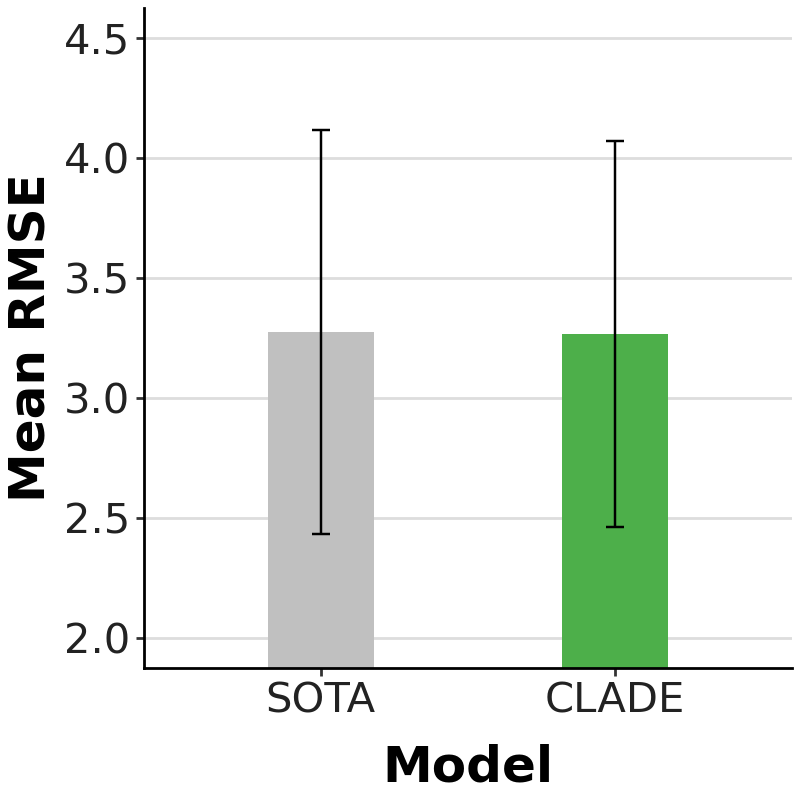

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_mean_rmse_delta_logit_SOTA_vs_CLADE_20251109_200942.eps
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_mean_rmse_delta_logit_SOTA_vs_CLADE_20251109_200942.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_mean_rmse_delta_logit_SOTA_vs_CLADE_20251109_200942.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_mean_rmse_delta_logit_SOTA_vs_CLADE_20251109_200942.pdf


In [28]:
from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar, scale_fill_manual,
    labs, theme_bw, theme, element_text, element_blank, position_dodge, coord_cartesian
)
from xml.etree import ElementTree as ET
import pandas as pd
import time
import matplotlib.pyplot as plt


def plot_mean_rmse_summary(sota_df, run1_df, metric_col, main_dir):
    """
    Compute mean ± std of Spearman correlation across all tissues for each model
    and plot a compact summary barplot (SOTA vs CLADE).
    """
    #  --- Standardize + merge ---
    # sota_df = sota_df[["tissue", metric_col]].assign(Model="SOTA")
    # run1_df = run1_df[["tissue", metric_col]].assign(Model="CLADE")
    sota_df["Model"] = "SOTA"
    run1_df["Model"] = "CLADE" 
    merged = pd.concat([sota_df, run1_df], ignore_index=True)

    # --- Enforce desired model order ---
    merged["Model"] = pd.Categorical(merged["Model"], categories=["SOTA", "CLADE"], ordered=True)

    # --- Compute mean ± std ---
    summary = (
        merged.groupby("Model")[metric_col]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    # --- Plot ---
    p = (
        ggplot(summary, aes(x="Model", y="mean", fill="Model"))
        + geom_bar(stat="identity", width=0.36)
        + geom_errorbar(
            aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
            width=0.06
        )
        + scale_fill_manual(values={"SOTA": "#c0c0c0", "CLADE": "#4daf4a"})
        + labs(x=None, y=r"Mean RMSE", fill=None)
        + theme_bw()
        + coord_cartesian(ylim=(2, 4.5))  # ✅ preferred approach
        # + theme(
        #     figure_size=(4, 4),
        #     legend_position="none",
        #     axis_text_x=element_text(size=13, weight="bold"),
        #     axis_text_y=element_text(size=12),
        #     axis_title_y=element_text(size=13, weight="bold"),
        #     axis_title_x=element_text(margin={'t': 8}, size=13, weight="bold"),
        #     panel_border=element_blank(),
        #     panel_grid_major_y=element_text(color="#dddddd"),
        #     panel_grid_minor_y=element_blank(),
        #     panel_grid_major_x=element_blank(),
        #     panel_grid_minor_x=element_blank(),
        #     axis_line_x=element_text(color="black"),
        #     axis_line_y=element_text(color="black"),
        #     plot_title=element_blank()
        # )
        + theme(
            figure_size=(4, 4),
            legend_position="none",
            axis_text_y=element_text(size=15, color="#222222"),
            axis_text_x=element_text(size=15, color="#222222"),
            axis_title_x=element_text(margin={'t': 8}, size=18, weight="bold"),
            axis_title_y=element_text(size=18, weight="bold"),
            plot_title=element_text(size=15, weight="bold", ha="center"),
            panel_border=element_blank(),
            panel_grid_major_y=element_text(color="#dddddd"),
            panel_grid_minor_y=element_blank(),
            panel_grid_major_x=element_blank(),
            panel_grid_minor_x=element_blank(),
            axis_line_x=element_text(color="black"),
            axis_line_y=element_text(color="black"),
        )
    )

    # --- Display in notebook ---
    p.show()

    # --- Save ---
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    out_path = f"{main_dir}/fig_TissueWise_ASCOT_mean_{metric_col}_SOTA_vs_CLADE_{timestamp}"
    
    
    fig = p.draw()
    fig.set_size_inches(4, 4)
    def normalize_svg_viewbox(svg_path, target_size=(400, 400)):
        tree = ET.parse(svg_path)
        root = tree.getroot()
        root.set("width", f"{target_size[0]}")
        root.set("height", f"{target_size[1]}")
        root.set("viewBox", f"0 0 {target_size[0]} {target_size[1]}")
        tree.write(svg_path)

    for fmt in ["eps", "png", "svg", "pdf"]:
        save_path = f"{out_path}.{fmt}"
        fig.savefig(
            save_path,
            dpi=300,
            facecolor="white",
            bbox_inches="tight", pad_inches=0
        )
        if fmt == "svg":
            normalize_svg_viewbox(save_path)
        print(f"✅ Saved: {save_path}")

    plt.close(fig)

main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"


plot_mean_rmse_summary(
    sota_df=sota_results['rmse_delta_logit'],
    run1_df=exp1_results["rmse_delta_logit"][['tissue', 'rmse_delta_logit']].copy(),
    metric_col="rmse_delta_logit",
    main_dir="/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"
)


Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/setting3_rmse_psi_SOTA_vs_300bp_MTCLSwept_10Aug_testdata_ensembled_vs_IntronONLY_NoCL_300bp_3p5pCut_ensembled_2025_11_16__01_00_39.png


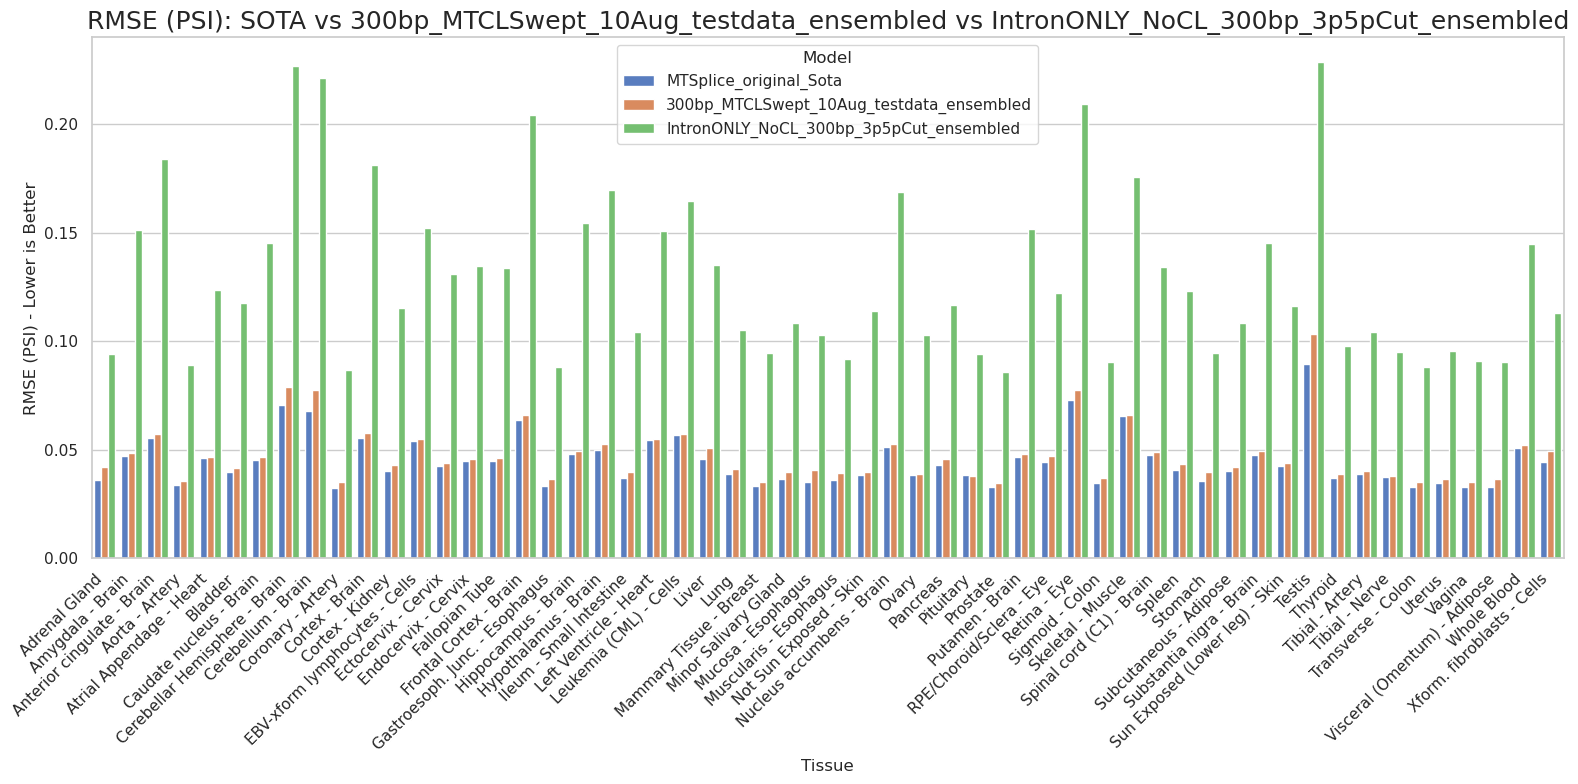

Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/setting3_rmse_delta_logit_SOTA_vs_300bp_MTCLSwept_10Aug_testdata_ensembled_vs_IntronONLY_NoCL_300bp_3p5pCut_ensembled_2025_11_16__01_00_39.png


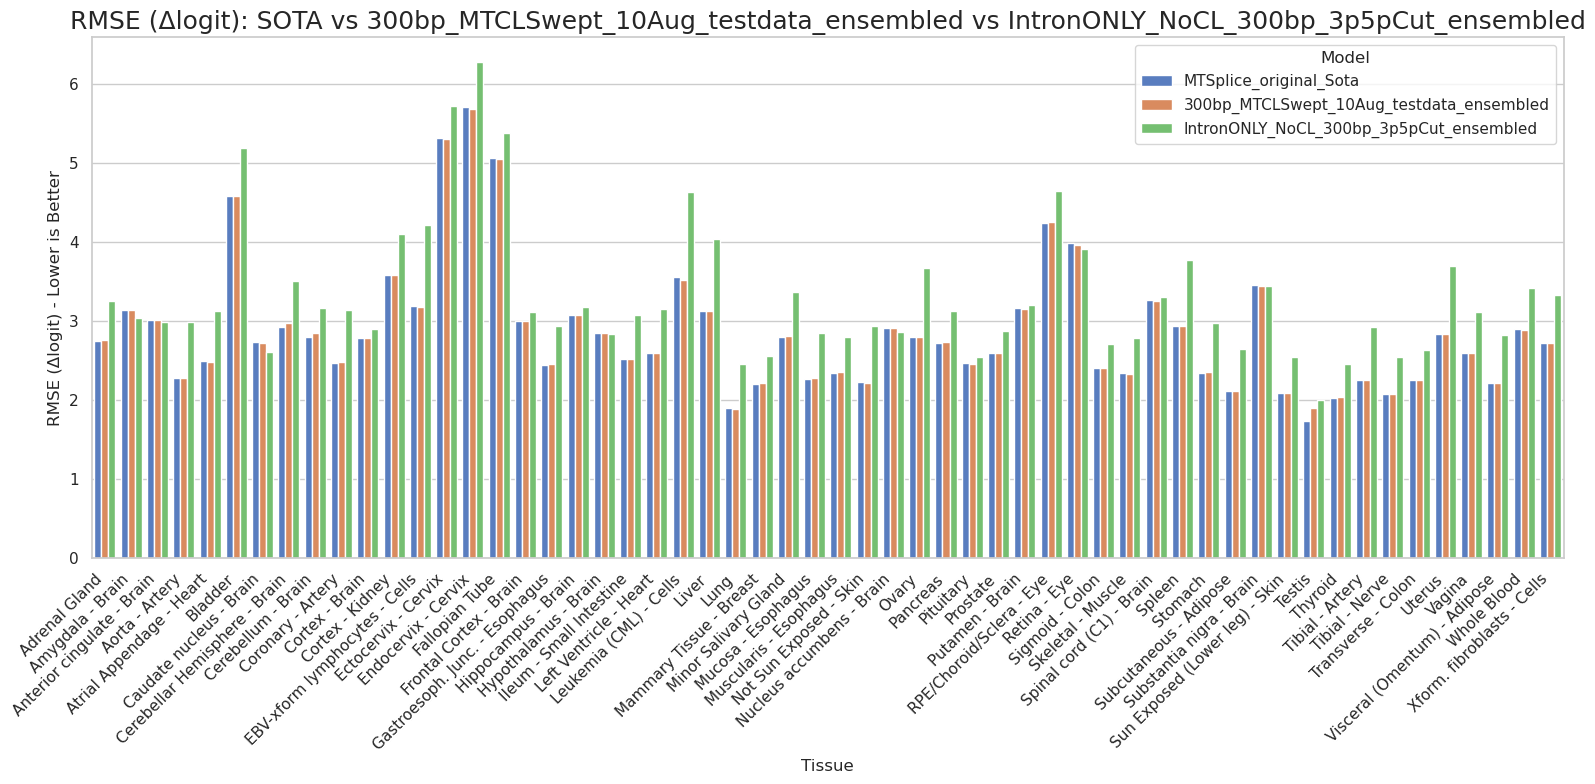

In [16]:
# --- Plotting Setting 3 (NOW FULLY FLEXIBLE) ---

# Choose 'rmse_psi', 'rmse_delta_psi', or 'rmse_delta_logit'
metric_to_plot_3 = 'rmse_psi'
# ---------------------------------------------------

# This code will now work perfectly
if metric_to_plot_3 == 'rmse_psi':
    title_label = "RMSE (PSI)"
elif metric_to_plot_3 == 'rmse_delta_psi':
    title_label = "RMSE (ΔPSI)"
else:
    title_label = "RMSE (Δlogit)"

title_3 = f"{title_label}: SOTA vs {model1_name} vs {model2_name}"
save_name_3 = f"setting3_{metric_to_plot_3}_SOTA_vs_{model1_name}_vs_{model2_name}"

generate_comparison_plot(
    title_3,
    save_name_3,
    (sota_results[metric_to_plot_3], metric_to_plot_3, sota_results['name']),
    (exp1_results[metric_to_plot_3], metric_to_plot_3, exp1_results['name']),
    (exp2_results[metric_to_plot_3], metric_to_plot_3, exp2_results['name'])
)


# Choose 'rmse_psi', 'rmse_delta_psi', or 'rmse_delta_logit'
metric_to_plot_3 = 'rmse_delta_logit'
# ---------------------------------------------------

# This code will now work perfectly
if metric_to_plot_3 == 'rmse_psi':
    title_label = "RMSE (PSI)"
elif metric_to_plot_3 == 'rmse_delta_psi':
    title_label = "RMSE (ΔPSI)"
else:
    title_label = "RMSE (Δlogit)"

title_3 = f"{title_label}: SOTA vs {model1_name} vs {model2_name}"
save_name_3 = f"setting3_{metric_to_plot_3}_SOTA_vs_{model1_name}_vs_{model2_name}"

generate_comparison_plot(
    title_3,
    save_name_3,
    (sota_results[metric_to_plot_3], metric_to_plot_3, sota_results['name']),
    (exp1_results[metric_to_plot_3], metric_to_plot_3, exp1_results['name']),
    (exp2_results[metric_to_plot_3], metric_to_plot_3, exp2_results['name'])
)

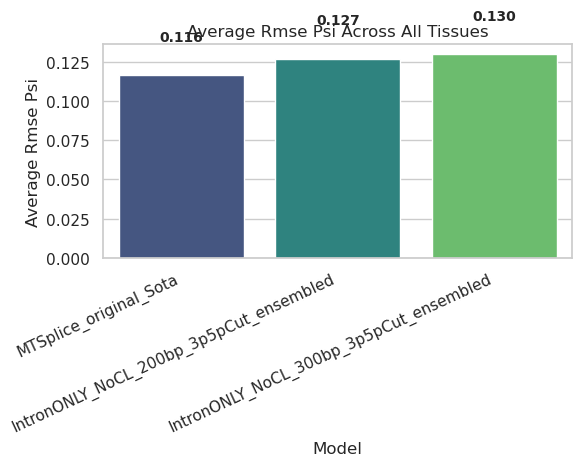

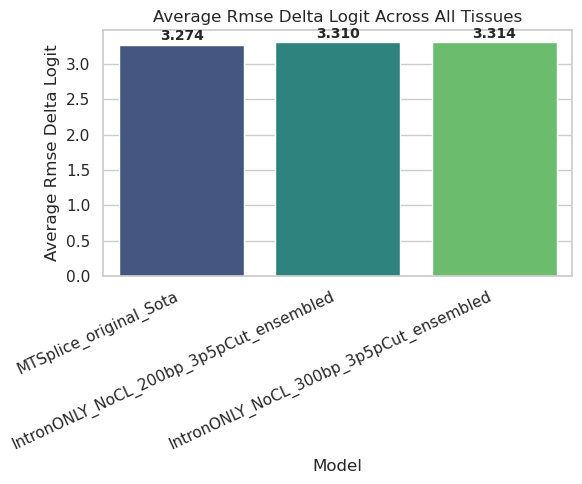

In [17]:
# Choose 'rmse_psi', 'rmse_delta_psi', or 'rmse_delta_logit'
metric_to_plot_2 = 'rmse_psi'
# ---------------------------------------------------

avg_df = plot_average_across_tissues_2models(
    sota=sota_results[metric_to_plot_2],
    df1=exp1_results[metric_to_plot_2],
    df2=exp2_results[metric_to_plot_2],
    sota_name=sota_model_name,
    model1_name=model1_name,
    model2_name=model2_name,
    metric=metric_to_plot_2,
)


metric_to_plot_2b = 'rmse_delta_logit'

avg_df = plot_average_across_tissues_2models(
    sota=sota_results[metric_to_plot_2b],
    df1=exp1_results[metric_to_plot_2b],
    df2=exp2_results[metric_to_plot_2b],
    sota_name=sota_model_name,
    model1_name=model1_name,
    model2_name=model2_name,
    metric=metric_to_plot_2b,
)

In [ ]:
# %%
#################################################################
# --- Plotting Setting 1: SOTA vs. User Prediction (Exp 3) ---
#################################################################
print(f"\n--- Generating Plot Setting 1: {sota_model_name} vs {model3_name} ---")

# You can only plot 'rmse_delta_logit' because SOTA only has this metric
metric_to_plot_1 = 'rmse_delta_logit' 
title_1 = f"RMSE (Δlogit): {sota_model_name} vs {model3_name}"
save_name_1 = f"setting1_rmse_delta_logit_{sota_model_name}_vs_{model3_name}"

generate_comparison_plot(
    title_1,
    save_name_1,
    (sota_results[metric_to_plot_1], metric_to_plot_1, sota_results['name']),
    (exp3_results[metric_to_plot_1], metric_to_plot_1, exp3_results['name'])
)

In [ ]:
# %%
#################################################################
# --- Plotting Setting 2: User (Exp 1) vs. User (Exp 2) ---
#################################################################
print(f"\n--- Generating Plot Setting 2: {model1_name} vs {model2_name} ---")

# --- Choose your metric ---
# Options: 'rmse_psi', 'rmse_delta_psi', 'rmse_delta_logit'
metric_to_plot_2 = 'rmse_delta_logit'
# --------------------------

title_2 = f"{metric_to_plot_2.upper()}: {model1_name} vs {model2_name}"
save_name_2 = f"setting2_{metric_to_plot_2}_{model1_name}_vs_{model2_name}"

generate_comparison_plot(
    title_2,
    save_name_2,
    (exp1_results[metric_to_plot_2], metric_to_plot_2, exp1_results['name']),
    (exp2_results[metric_to_plot_2], metric_to_plot_2, exp2_results['name'])
)

# --- (Optional) Plot another metric from this setting ---
metric_to_plot_2b = 'rmse_psi'
title_2b = f"{metric_to_plot_2b.upper()}: {model1_name} vs {model2_name}"
save_name_2b = f"setting2_{metric_to_plot_2b}_{model1_name}_vs_{model2_name}"

generate_comparison_plot(
    title_2b,
    save_name_2b,
    (exp1_results[metric_to_plot_2b], metric_to_plot_2b, exp1_results['name']),
    (exp2_results[metric_to_plot_2b], metric_to_plot_2b, exp2_results['name'])
)

In [ ]:
# %%
#################################################################
# --- Scatter Plot Generation (True vs. Predicted) ---
# --- Plot ΔPSI and Δlogit(Ψ) for a specific tissue ---
#################################################################

# --- Configure your plot ---
tissue_to_plot = "Retina - Eye"
model_to_plot = exp3_results # Choose: sota_results, exp1_results, exp2_results, exp3_results
# ---------------------------

print(f"\n--- Generating Scatter Plots for {model_to_plot['name']} in {tissue_to_plot} ---")

# --- 1. Plot Delta PSI (ΔΨ) ---
# SOTA does not have this, so we must check
if 'pred_delta_psi_long' in model_to_plot:
    value_type_1 = "ΔPSI"
    
    # Filter GT and Pred data
    gt_data_dpsi = gt_delta_psi_long[gt_delta_psi_long['tissue'] == tissue_to_plot]
    pred_data_dpsi = model_to_plot['pred_delta_psi_long'][model_to_plot['pred_delta_psi_long']['tissue'] == tissue_to_plot]
    
    # Merge to align on exon_id
    scatter_data_dpsi = pd.merge(
        gt_data_dpsi,
        pred_data_dpsi,
        on=['exon_id', 'tissue']
    ).dropna()
    
    if scatter_data_dpsi.empty:
         print(f"Warning: No overlapping {value_type_1} data found for tissue '{tissue_to_plot}'. Skipping scatter plot.")
    else:
        save_path_1 = f"{fig_maindir}/scatter_delta_psi_{tissue_to_plot.replace(' - ', '_')}_{model_to_plot['name']}{trimester}.png"
        plot_scatter_comparison(
            y_true=scatter_data_dpsi['gt_delta_psi'],
            y_pred=scatter_data_dpsi['pred_delta_psi'],
            tissue=tissue_to_plot,
            value_type=value_type_1,
            model_name=model_to_plot['name'],
            save_path=save_path_1
        )
else:
    print(f"Skipping ΔPSI scatter for {model_to_plot['name']} (data not available).")


# --- 2. Plot Delta Logit PSI (Δlogit(Ψ)) ---
if 'pred_delta_logit_long' in model_to_plot:
    value_type_2 = "Δlogit"
    
    # Filter GT and Pred data
    gt_data_dlogit = gt_delta_logit_long[gt_delta_logit_long['tissue'] == tissue_to_plot]
    pred_data_dlogit = model_to_plot['pred_delta_logit_long'][model_to_plot['pred_delta_logit_long']['tissue'] == tissue_to_plot]

    # Merge to align on exon_id
    scatter_data_dlogit = pd.merge(
        gt_data_dlogit,
        pred_data_dlogit,
        on=['exon_id', 'tissue']
    ).dropna()
    
    if scatter_data_dlogit.empty:
         print(f"Warning: No overlapping {value_type_2} data found for tissue '{tissue_to_plot}'. Skipping scatter plot.")
    else:
        save_path_2 = f"{fig_maindir}/scatter_delta_logit_{tissue_to_plot.replace(' - ', '_')}_{model_to_plot['name']}{trimester}.png"
        plot_scatter_comparison(
            y_true=scatter_data_dlogit['gt_delta_logit'],
            y_pred=scatter_data_dlogit['pred_delta_logit'],
            tissue=tissue_to_plot,
            value_type=value_type_2,
            model_name=model_to_plot['name'],
            save_path=save_path_2
        )
else:
    print(f"Skipping Δlogit scatter for {model_to_plot['name']} (data not available).")

In [ ]:
# %%
#################################################################
# --- Histogram Generation (True vs. Predicted) ---
#################################################################

# --- Configure your plot ---
tissue_to_plot_hist = "Retina - Eye"
model_to_plot_hist = exp3_results # Choose: sota_results, exp1_results, exp2_results, exp3_results
metric_to_plot_hist = "delta_logit" # Choose: 'psi', 'delta_psi', 'delta_logit'
# ---------------------------

print(f"\n--- Generating {metric_to_plot_hist} Histogram for {model_to_plot_hist['name']} in {tissue_to_plot_hist} ---")

# Define GT and Pred data based on choice
try:
    gt_data_hist = globals()[f'gt_{metric_to_plot_hist}_long']
    pred_data_hist = model_to_plot_hist[f'pred_{metric_to_plot_hist}_long']
    
    gt_col_hist = f'gt_{metric_to_plot_hist}'
    pred_col_hist = f'pred_{metric_to_plot_hist}'
    
    # Filter for tissue
    gt_tissue_data = gt_data_hist[gt_data_hist['tissue'] == tissue_to_plot_hist][gt_col_hist].dropna()
    pred_tissue_data = pred_data_hist[pred_data_hist['tissue'] == tissue_to_plot_hist][pred_col_hist].dropna()

    if gt_tissue_data.empty or pred_tissue_data.empty:
            print(f"Warning: No data found for tissue '{tissue_to_plot_hist}'. Skipping histogram.")
    else:
        hist_save_path = f"{fig_maindir}/histogram_{metric_to_plot_hist}_{tissue_to_plot_hist.replace(' - ', '_')}_{model_to_plot_hist['name']}{trimester}.png"
        
        plot_histogram(
            y_true=gt_tissue_data,
            y_pred=pred_tissue_data,
            tissue=tissue_to_plot_hist,
            value_type=metric_to_plot_hist,
            save_path=hist_save_path
        )
except KeyError:
    print(f"Error: Metric '{metric_to_plot_hist}' not found for {model_to_plot_hist['name']}. Skipping histogram.")
except Exception as e:
    print(f"An error occurred during histogram generation: {e}")

print("\n--- Script Finished ---")